## Initialization

In [44]:
import numpy as np
import pandas as pd
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
# first dataset
df1 = pd.read_csv('data/cpu4.csv')
df1 = df1.sort_values(by = 'timestamp', ascending=True)
df1 = df1.replace({'label': {0.0: False, 1.0: True}})

df1.head(1)

C:\Users\user\AppData\Local\Temp\ipykernel_13508\2450595631.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1 = df1.replace({'label': {0.0: False, 1.0: True}})


,timestamp,value,label
0,1469376000,0.8473,False


In [46]:
# second dataset
df2 = pd.read_csv('data/g.csv')
df2 = df2.sort_values(by='timestamp', ascending=True)
df2 = df2.replace({'label': {0.0: False, 1.0: True}})
df2.head(1)

,timestamp,value,label
0,1476460800,0.012604,False


### Frequency of Anomalies

In [47]:
print('Frequencies:')
print(df1.label.value_counts(normalize=True), '\n')
print(df2.label.value_counts(normalize=True))

Frequencies:
label
False    0.988103
True     0.011897
Name: proportion, dtype: float64 

label
False    0.941314
True     0.058686
Name: proportion, dtype: float64


### Anomalies in the Dataset
Let's visualize the datasets

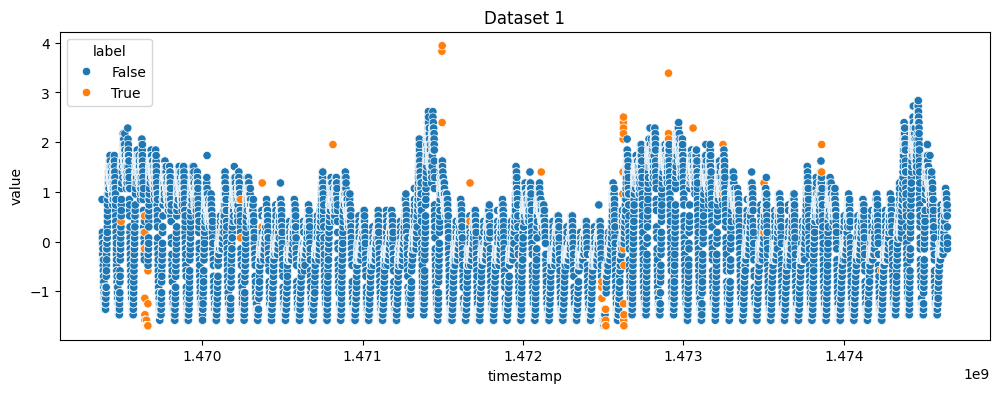

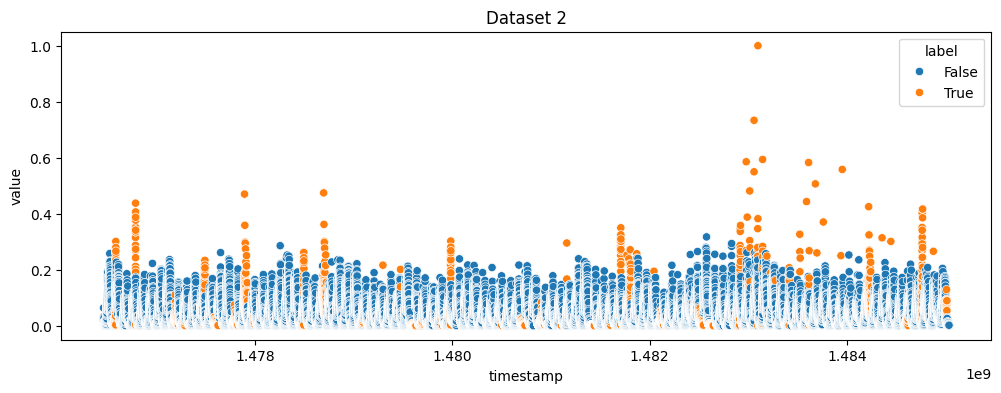

In [48]:
plt.figure(figsize=(12,4))
plt.title('Dataset 1')
sns.scatterplot(data=df1, x='timestamp', y='value', hue='label')
plt.show()

plt.figure(figsize=(12,4))
plt.title('Dataset 2')
sns.scatterplot(data=df2, x='timestamp', y='value', hue='label')
plt.show()

- explore only 300 points of each dataset

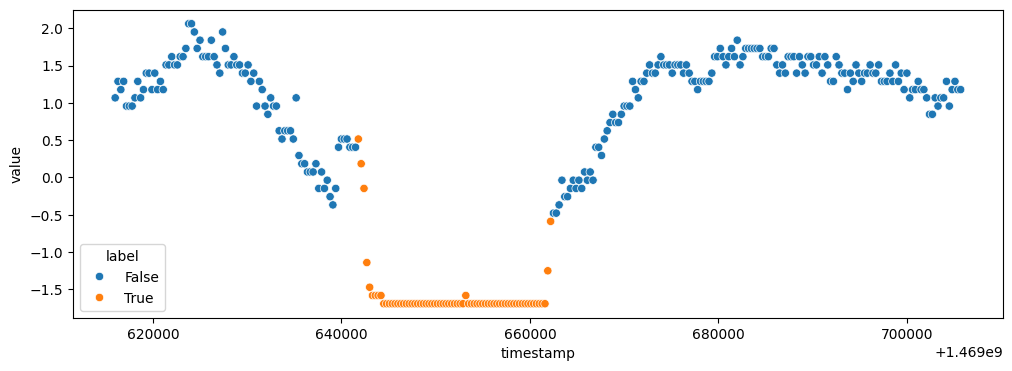

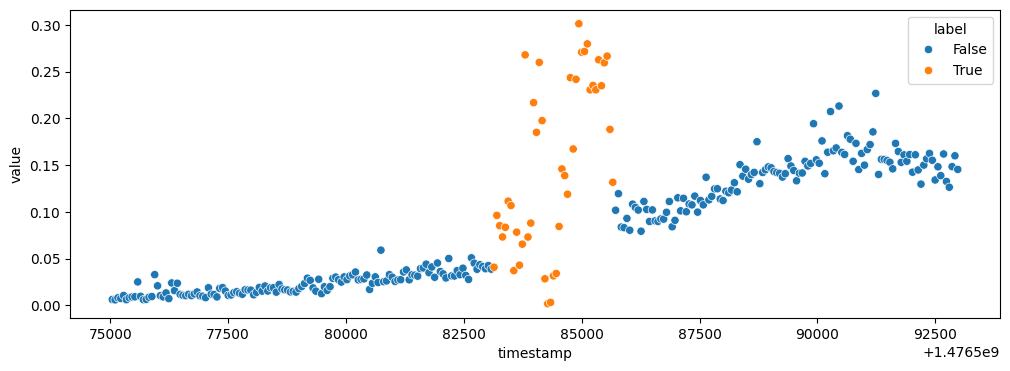

In [49]:
df1_zoom = df1[800:1100]
df1_zoom_exp = df1[300:1800]
plt.figure(figsize=(12,4))
sns.scatterplot(data=df1_zoom, x='timestamp', y='value', hue='label')
plt.show()

df2_zoom = df2[1900:2200]
plt.figure(figsize=(12,4))
sns.scatterplot(data=df2_zoom, x='timestamp', y='value', hue='label')
plt.show()

## Tech#1: Moving Average
Moving average is the most common type of average used in Time Series problems.
We perform the sum of recent data points and divide them by the time period. Further, we simply check if the new record is far from the expected value. The expected value range is computed using the formula Moving Average + standard deviation * threshold; if it is out of the expected value range, we report as an anomaly.

In [50]:
class StreamingMovingAverage:
    '''Moving Average algorithm'''
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html

    def __init__(self, threshold=1.0) -> None:
        # Parameters
        self.max_deviation_from_expected = threshold
        self.min_nof_records_in_model = 3
        self.max_nof_records_in_model = 3 * self.min_nof_records_in_model

    def detect(self, timestamp: int, value: float, dumping: bool=False) -> bool:
        '''Detect if is a Anomaly'''
        self._update_state(timestamp, value)
        expected_value = self._expected_value(timestamp)
        # is there enough data and is not NaN value
        response, curr_value, deviation = False, value, 0.0
        if self._enough_data() and not np.isnan(expected_value):
            # is the value out of the boundary? when it decrease
            curr_value = expected_value
            deviation = self._standard_deviation() * self.max_deviation_from_expected
            # when it is higher than expected
            if expected_value + deviation < value or\
               expected_value - deviation > value:
                response = True
        # dumping or not
        if dumping: return (response, curr_value, deviation)
        else: return response

    def _update_state(self, timestamp: int, value: float) -> None:
        '''Update the model state'''
        # check if it is the first time the model is run or if there is a big interval between the timestamps
        if not hasattr(self, 'previous_timestamp'):
            self._init_state(timestamp)
        # update the model state
        self.previous_timestamp = timestamp
        self.data_streaming.append(value)
        # is there a lot of data? remove one record
        if len(self.data_streaming) > self.max_nof_records_in_model:
            self.data_streaming.pop(0)

    def _init_state(self, timestamp: int) -> None:
        '''Reset the parameters'''
        self.previous_timestamp = timestamp
        self.data_streaming = list()

    def _enough_data(self) -> bool:
        '''Check if there is enough data'''
        return len(self.data_streaming) >= self.min_nof_records_in_model

    def _expected_value(self, timestamp: int) -> float:
        '''Return the expected value'''
        data = self.data_streaming
        data = pd.Series(data=data, dtype=float)
        many = self.min_nof_records_in_model
        return data.rolling(many, min_periods=1).mean().iloc[-1]

    def _standard_deviation(self) -> float:
        '''Return the standard deviation'''
        data = self.data_streaming
        return np.std(data, axis=0)

    def get_state(self) -> dict:
        '''Get the state'''
        self_dict = {key: value for key, value in self.__dict__.items()}
        return pickle.dumps(self_dict, 4)

    def set_state(self, state) -> None:
        '''Set the state'''
        _self = self
        ad = pickle.loads(state)
        for key, value in ad.items():
            setattr(_self, key, value)

# Example
# ad = StreamingMovingAverage(threshold=1.5)
# ad.detect(timestamp=123, value=10)
# ad.detect(timestamp=124, value=7)

### Exploring the Data
You can note that the MA is too sensitive to data. Any abrupt change it is notified as anomaly. In this sense, for each streaming data, you have to fit the threshold. However, remember that a high threshold cannot find any anomaly.

Also, we can note that when the data behaviour change, the algorithm is able to quickly adapt and learn the new behaviour. Another advantage of this algorithm is it only notify the anomaly once, and the sequential anomaly data (with similar behaviour) is ignored due to the sensibility of the algorithm, avoiding multiples "anomaly alerts"

In [60]:
def plot_anomalies(df, algorithm, parameters, dumping=False, casting=None):
    '''Plot the Streaming Data (an Anomalies)'''
    Y = df.value
    X = df.timestamp
    X_pred = df.timestamp if casting is None else X.apply(casting)

    # predict anomalies
    model = algorithm(**parameters)
    preds = [model.detect(i, v, dumping=True) for i, v in zip(X_pred, Y)]
    
    pred, values, stds = tuple(zip(*preds))

    # plot the results
    plt.figure(figsize=(12, 4))
    model_name = algorithm.__name__
    plt.title(f'Anomaly Detection - {model_name}')
    af  = pd.DataFrame(data={'x': X, 'value': Y, 'pred': pred})
    af2 = pd.DataFrame(data={'x': X, 'value': values, 'pred': pred, 'std': stds})
    af2['ymin'] = af2['value'] - af2['std']
    af2['ymax'] = af2['value'] + af2['std']
    size = (af['pred'].astype(int)+1) * 40
    sns.scatterplot(data=af, x='x', y='value', hue='pred', s=size.iloc[0])

    if dumping:
        plt.fill_between(af2.x, af2.ymin, af2.ymax, facecolor='green', alpha=0.2)
        plt.show()

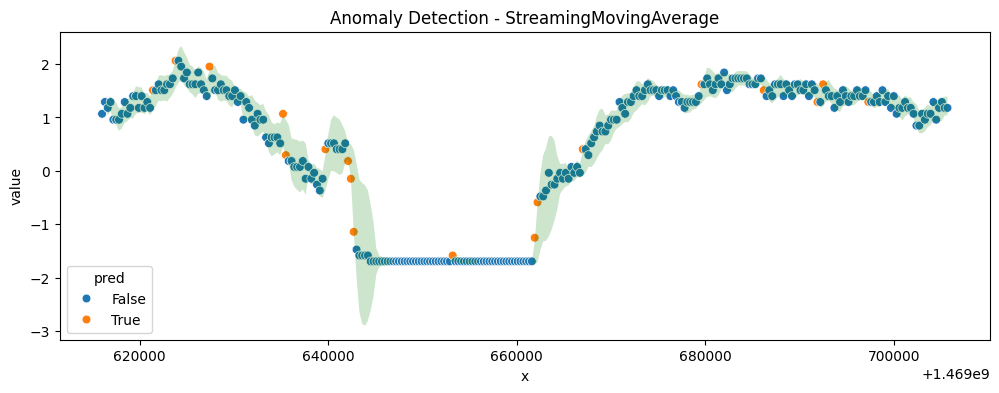

In [61]:
parameters = {'threshold': 1.5}
plot_anomalies(df1_zoom, StreamingMovingAverage, parameters, dumping=True)

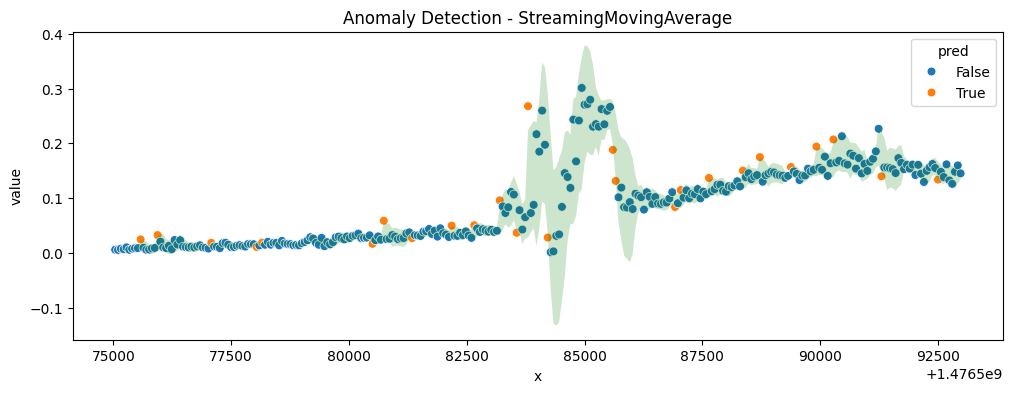

In [62]:
parameters = {'threshold': 1.5}
plot_anomalies(df2_zoom, StreamingMovingAverage, parameters, dumping=True)

## Exponential Moving Average

Exponential Moving Average focuses more on recent data by assigning more weight to new data points; so, they were weighted by timestamp - most recent has more importance. Further, we simple check if the new record is far from the expected value. The expected value range is computed using the formula `Exponential Moving Average + standard deviation * threshold`; if it is out of the expected value range, we report as an anomaly.

Also, the Exponential Moving Average needs a parameter called `alpha` that determines the importance of the last record, and its value is decreased for the next records. For example, if `alpha=0.5`: the record-1 has 50% of importance, the record-2 has 30% of importance, and so on. Thus, this weighted algorithm enables smooth the exected value.

In [40]:
class StreamingExponentialMovingAverage(StreamingMovingAverage):
    '''Exponential Weighted Moving Average (EWMA) Algorithm'''
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.ewm.html

    def __init__(self, threshold=1.0, alpha=0.3) -> None:
        super().__init__()
        # Parameters
        self.max_deviation_from_expected = threshold
        self.alpha = alpha

    def _enough_data(self) -> bool:
        '''Check if there is enough data'''
        return len(self.data_streaming) > 0

    def _expected_value(self, timestamp: int) -> float:
        '''Return the expected value'''
        data = self.data_streaming
        data = pd.Series(data=data, dtype=float)
        return data.ewm(alpha=self.alpha, adjust=True).mean().iloc[-1]

# Example
ad = StreamingExponentialMovingAverage(threshold=1.5, alpha=0.45)
ad.detect(timestamp=123, value=10)
ad.detect(timestamp=124, value=7)

False

### Exploring the Data

You can note that the **Exponential Moving Average** is more smooth to changes than the simple **Moving Average**. However, this algorithm has two parameters to be defined by the user, they are `threshold` and `alpha`.

Again, we can note that when the data behaviour change, the algorithm is able to quickly adapt and learn the new behaviour. Another advantage of this algorithm is it only notify the anomaly once, and teh sequential anomaly data (With similar behaviour) is ignored due to the sensibility of the algorithm, avoiding multiples 'anomaly alerts'

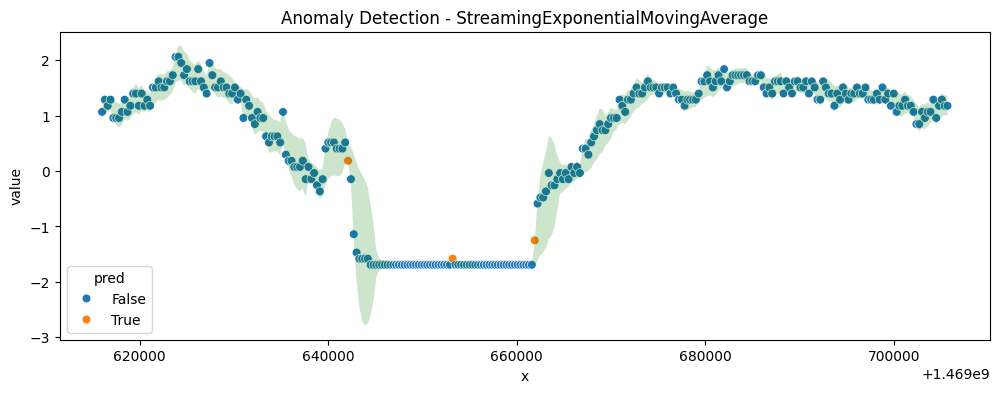

In [63]:
parameters = {'threshold': 1.5, 'alpha': 0.45}
plot_anomalies(df1_zoom, StreamingExponentialMovingAverage, parameters, dumping=True)


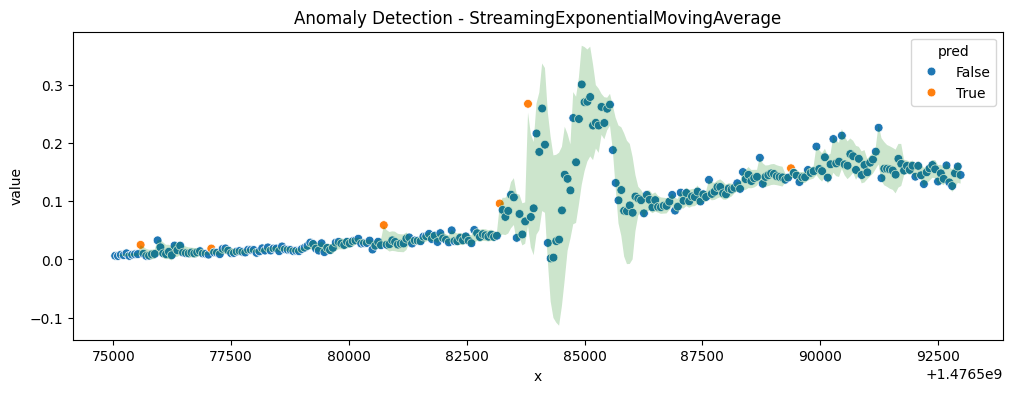

In [64]:
parameters = {'threshold': 1.5, 'alpha': 0.45}
plot_anomalies(df2_zoom, StreamingExponentialMovingAverage, parameters, dumping=True)

## Seasonal Moving Average

As for the Seasonal Moving Average, it's a time-based algorithm that compares specific days of the week over a period of time to identify patterns or trends. This technique is particularly useful in situations where there are regular seasonal fluctuations in the data, such as daily or weekly cycles. However, this method requires a sufficient amount of historical data to be effective, and it may not be suitable for our sample data, which is not seasonal and has a limited number of data points.

In [75]:
import numpy as np
import pandas as pd
import datetime as dt

from typing import Union

MINUTES_HOUR = 60 # minutes per hour
MINUTES_DAY = 24 * MINUTES_HOUR # minutes per day
NUMBER_DAYS_WEEK = 7 # number days a week


class AnomalyDetectionSeasonalBucket(StreamingMovingAverage):

    def __init__(self, min_buckets: int, window: int=4, min_value: int=10, threshold: float=2) -> None:
        '''Min number of messages is 1 per minute'''
        super().__init__()
        # parameters
        self.min_buckets = min_buckets
        self._num_bucket = int(np.floor(MINUTES_DAY / min_buckets))
        self.window_size = window
        self.min_value = min_value
        self.max_deviation_from_expected = threshold

    def _get_cday_cbucket(self, timestamp: dt.datetime) -> tuple:
        '''Get cday, cbucket values from timestamp'''
        # compute bucket indexes
        cday, chour, cminute = timestamp.weekday(), timestamp.hour, timestamp.minute
        cbucket = int(np.floor((chour * MINUTES_HOUR + cminute) / self.min_buckets))
        return cday, cbucket
    
    def _create_copy_data(self, timestamp: dt.datetime) -> np.array:
        '''Get data based on timestamp'''
        # compute bucket indexes, get data
        cday, cbucket = self._get_cday_cbucket(timestamp = timestamp)
        data = np.copy(self._buckets[cday, cbucket])
        data[data == 0.0] = np.nan
        return data
    
    def _update_state(self, timestamp: dt.datetime, value: float) -> None:
        '''Update the model state'''
        # check if it is the first run
        if not hasattr(self, 'previous_timestamp'):
            self._init_state(timestamp)
        # compute bucket indexes
        cday, cbucket = self._get_cday_cbucket(timestamp = timestamp)
        # shift values, empty days
        pass_days = int(np.ceil((timestamp - self._buckets_timestamp[cday, cbucket]).days / NUMBER_DAYS_WEEK))
        
        self._buckets[cday, cbucket] = np.roll(self._buckets[cday, cbucket], pass_days)
        self._buckets[cday, cbucket, 0:pass_days] = 0
        # update the model state
        self.previous_timestamp = timestamp
        self._buckets_timestamp[cday, cbucket] = timestamp

       
        self._buckets[cday, cbucket, 0] = self._buckets[cday, cbucket, 0] + value

    def _init_state(self, timestamp: dt.datetime) -> None:
        '''Reset the parameters'''
        self.previous_timestamp = timestamp
        self._buckets = np.zeros((NUMBER_DAYS_WEEK, self._num_bucket, self.window_size))
        
        self._buckets_timestamp = np.full((NUMBER_DAYS_WEEK, self._num_bucket), timestamp, dtype=dt.datetime)

    def _expected_value(self, timestamp: dt.datetime) -> float:
        '''Return the expected value'''
        data = self._create_copy_data(timestamp = timestamp)
        return np.nanmean(data)

    def _enough_data(self) -> bool:
        '''Check if there is enough data'''
        data = self._create_copy_data(timestamp = self.previous_timestamp)
        records = self.window_size - np.sum(np.isnan(data))
        return records >= min(self.min_nof_records_in_model, self.window_size)

    def _standard_deviation(self) -> float:
        '''Return the standard deviation'''
        # compute bucket indexes, get data
        data = self._create_copy_data(timestamp = self.previous_timestamp)
        return np.nanstd(data)
    
# Example
ad = AnomalyDetectionSeasonalBucket(min_buckets=60, window=5)
ad.detect(timestamp=dt.datetime(2023, 1, 23, 23, 40), value=10)
ad.detect(timestamp=dt.datetime(2023, 1, 30, 23, 40), value=7)

False

### Exploring the Data

**Seasonal Moving Average** is a time-based algorithm that relies on previous record data to make predictions, latest `window` days. It is particularly useful when analyzing patterns in seasonal data, such as weather or holiday sales. However, it is not suitable for our sample data as it does not exhibit any seasonal patterns and lacks enough days of data for analysis.
<br>
<br>
In contrast, the Exponential Moving Average is a more versatile algorithm that can adapt to changes in data behavior. It produces a smoother curve that is less affected by sudden outliers. To use this algorithm, two parameters must be defined by the user: threshold and alpha.

<built-in method fromtimestamp of type object at 0x00007FFDD3E58FA0>


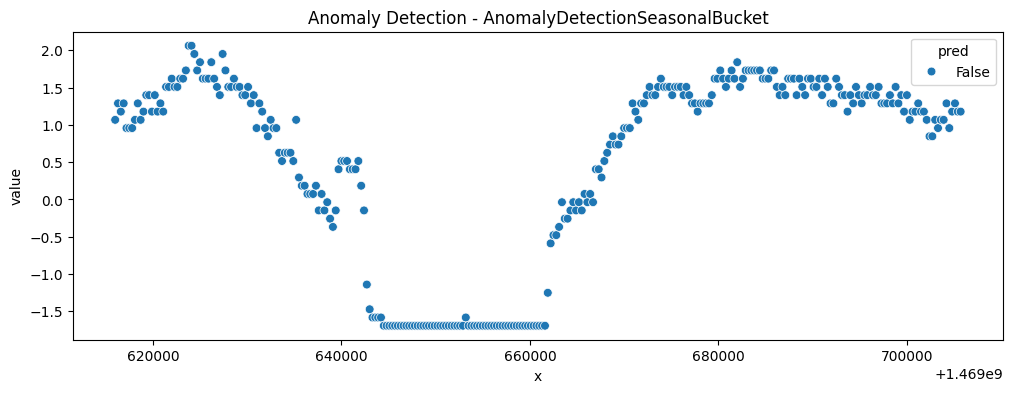

In [77]:
parameters = {'min_buckets': 30, 'window': 2}
print(dt.datetime.fromtimestamp)
plot_anomalies(df1_zoom, AnomalyDetectionSeasonalBucket, parameters, dumping=True, casting=dt.datetime.fromtimestamp)

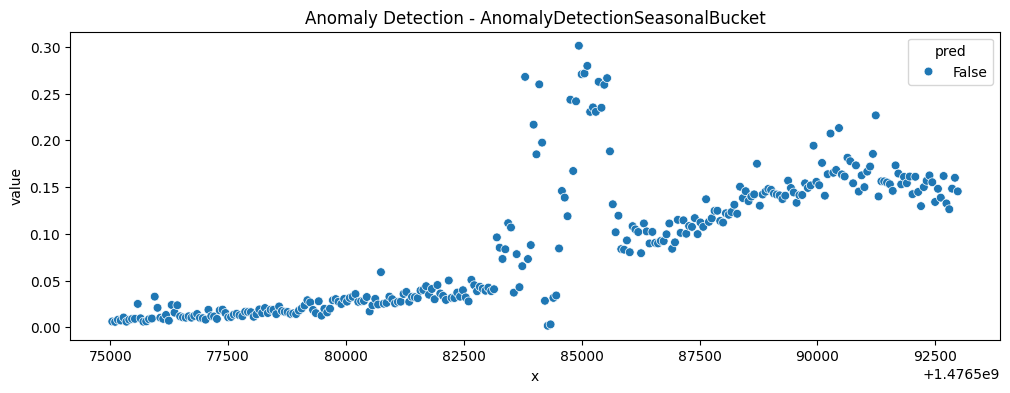

In [78]:
parameters = {'min_buckets': 30, 'window': 2}
plot_anomalies(df2_zoom, AnomalyDetectionSeasonalBucket, parameters, dumping = True, casting=dt.datetime.fromtimestamp)


When visualizing a larger set of data, the presence of anomalies may become more apparent. However, it is important to keep in mind that the accuracy of anomaly predictions heavily depends on the nature and patterns of the data being analyzed.
<br>
<br>
For instance, if the data being analyzed is not seasonal, then the predictions made by a seasonal algorithm may not be accurate. This is because seasonal algorithms rely on the assumption that certain patterns in the data repeat over time, which is not the case for non-seasonal data.

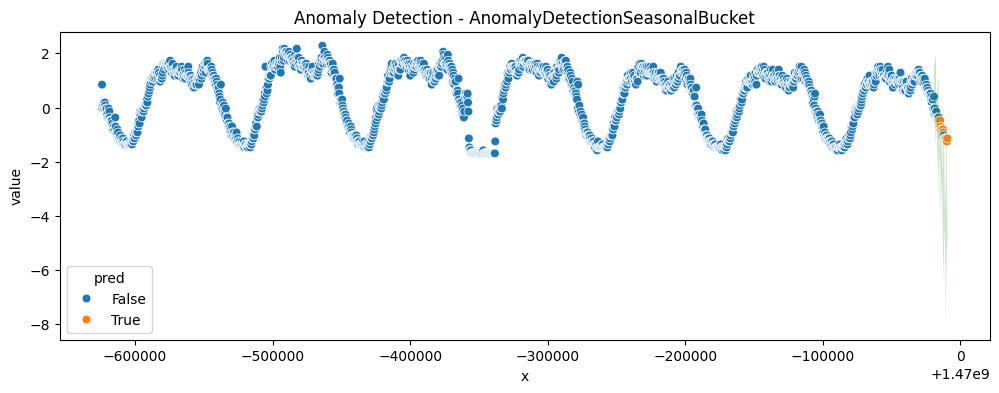

In [79]:
parameters = {'min_buckets': 30, 'window':2}
plot_anomalies(df1.iloc[0:2050], AnomalyDetectionSeasonalBucket, parameters, dumping=True, casting=dt.datetime.fromtimestamp)

## Auto Regressive Integrated Moving Average - ARIMA

**ARIMA** is an acronym that stands for AutoRegressive Integrated Moving Avage. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration. ARIMA is capable of predict values according to its previous observations. Further, we simple check if the new record is far from the expected value. The expected value range is computed using the formula `ARIMA + standard deviation * threshold`; if it is out of the expected value range, we report as an anomaly.

Note, the ARIMA requires a parameter called `order = (p, d, q)`, they are:
- `p`: number of autoregressive terms (AR order)
- `d`: number of nonseasonal differences (differencing order)
- `q`: number of moving-average terms (MA order)

In [84]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

class StreamingARIMA(StreamingMovingAverage):
    '''ARIMA algorithm'''
    def __init__(self, threshold=1.0, order:tuple=(2, 1, 2)) -> None:

        # Parameters
        self.order = order
        self.model = None
        self.res   = None
        self.max_deviation_from_expected = threshold
        self.min_nof_records_in_model = 10
        self.max_nof_records_in_model = 3 * self.min_nof_records_in_model

    def _expected_value(self, timestamp:int) -> float:
        '''Return the expected value'''
        if self._enough_data():
            data = self.data_streaming
            self.model = ARIMA(data, order=self.order)
            self.res   = self.model.fit()
            output     = self.res.forecast()
            return output[0]
        return np.nan

    def _standard_deviation(self) -> float:
        '''Return the standard deviation'''
        much = self.min_nof_records_in_model
        data = self.data_streaming
        if len(data) > much:
            data = data[-much:]
        return np.std(data, axis=0)

    def summary(self) -> None:
        '''Print the ARIMA summary'''
        if pd.notnull(self.res):
            print(self.res.summary())

### Is ARIMA accurate?
measure with RMSE

Test RMSE: 0.083


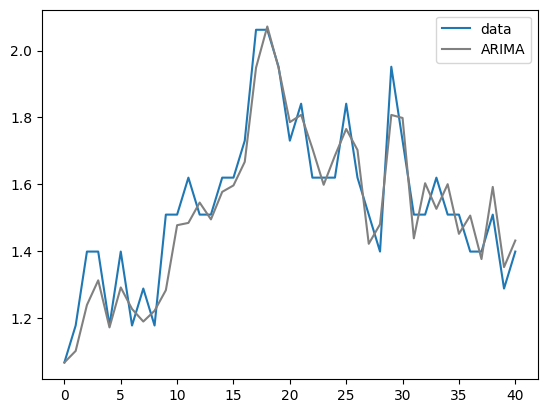

In [86]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# walk-forward validation
X = df1_zoom.iloc[0:50].value.tolist()
tests, predictions = list(), list()
model = StreamingARIMA()

for t in range(len(X)):
    obs = X[t]
    model.detect(t, obs)
    yhat = model._expected_value(0)
    if pd.notna(yhat):
        predictions.append(yhat)
        tests.append(obs)

# evaluate forecasts
rmse = sqrt(mean_squared_error(tests, predictions))

print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(tests, label = 'data')
plt.plot(predictions, color='gray', label='ARIMA')
plt.legend()
plt.show()

In [87]:
model.summary()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  11.673
Date:                Sat, 27 Jan 2024   AIC                            -13.346
Time:                        14:26:53   BIC                             -6.510
Sample:                             0   HQIC                           -11.205
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3804      0.881     -0.432      0.666      -2.106       1.346
ar.L2          0.4879      0.341      1.433      0.152      -0.180       1.155
ma.L1          0.0046      0.962      0.005      0.9

### Exploring the Data

You can note that the **ARIMA** is more accurate than previous methods. However, this algorithm has fours parameters to be defined by the user, they are `threshold` and three `orders`
<br>
<br>
Drawback: hard to finetune for the data

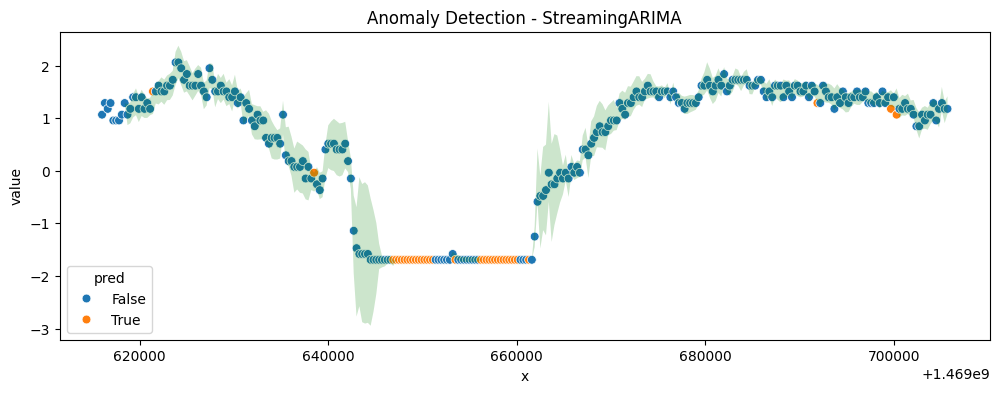

CPU times: total: 19 s
Wall time: 1min 46s


In [89]:
%%time

parameters = {'threshold': 1.5, 'order': (2, 1, 2)}
plot_anomalies(df1_zoom, StreamingARIMA, parameters, dumping=True)

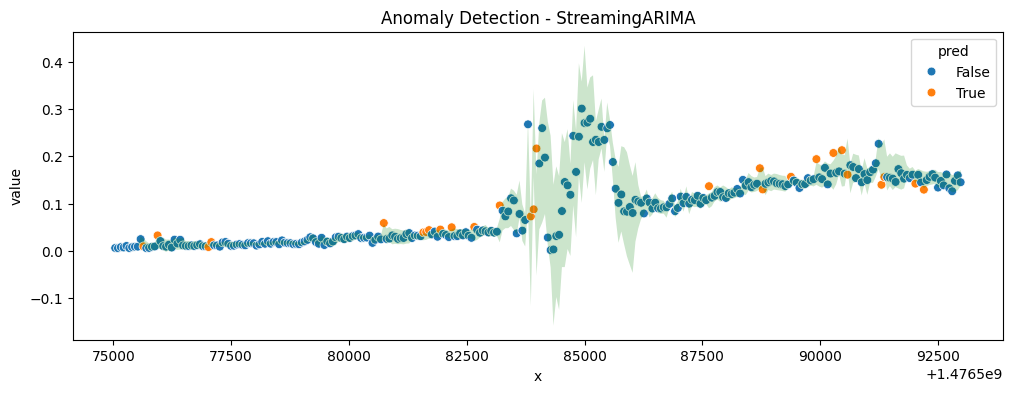

In [90]:
parameters = {'threshold': 1.5, 'order': (2, 1, 2)}
plot_anomalies(df2_zoom, StreamingARIMA, parameters, dumping=True)

## Conclusion

(1) We can see that **Exponential Moving Average** smooths the prediction better than the simple **Moving Average**. For the first dataset, the algorithm was able to detect the exact point of the anomaly and quickly adjust the prediction behaviour, avoiding multiples 'sequential anomaly alerts'

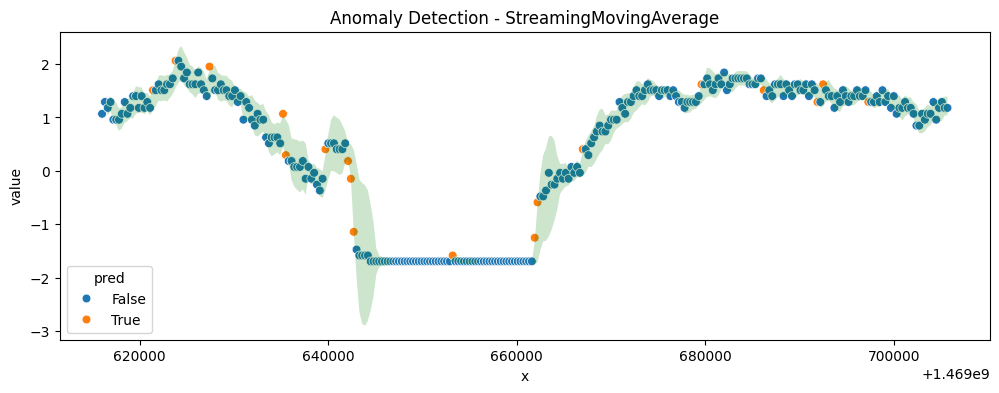

In [91]:
parameters = {'threshold': 1.5}
plot_anomalies(df1_zoom, StreamingMovingAverage, parameters, dumping=True)

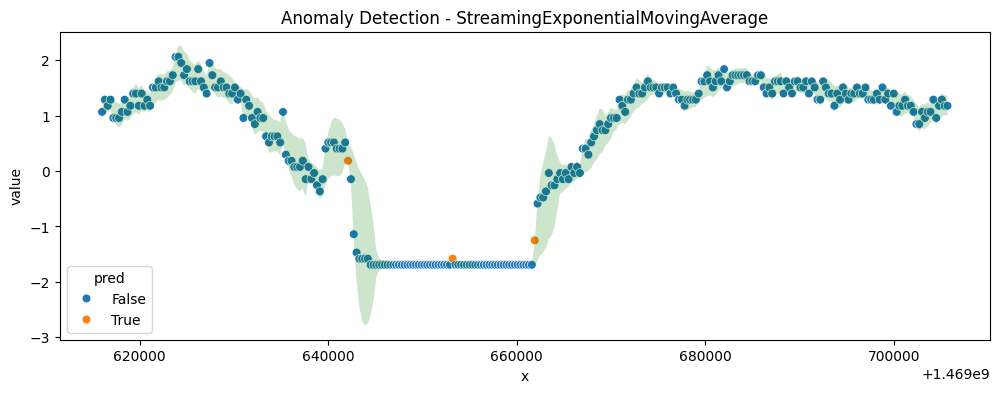

In [92]:
parameters = {'threshold': 1.5, 'alpha': 0.45}
plot_anomalies(df1_zoom, StreamingExponentialMovingAverage, parameters, dumping=True)

(2) Again, we can see the **Exponential Movng Average** smooths the prediction better than the simple Moving Average. However, the second dataet was more difficult than the first one, due to the high variation in the data. Anyway, the algorithm was able to detect the anomaly point, also produce a few false negative

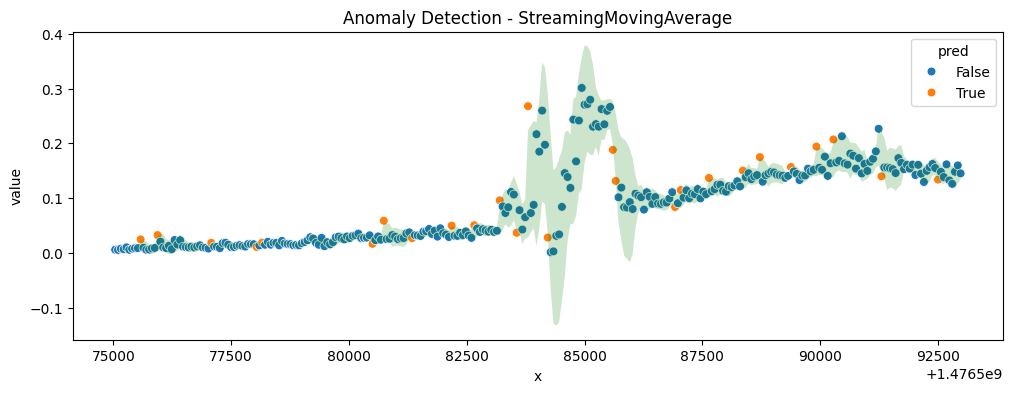

In [93]:
parameters = {'threshold': 1.5}
plot_anomalies(df2_zoom, StreamingMovingAverage, parameters, dumping=True)


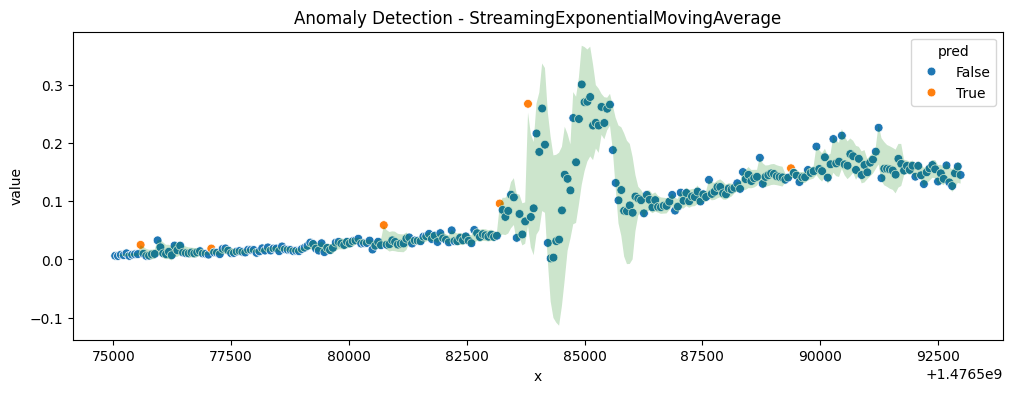

In [94]:
parameters = {'threshold': 1.5, 'alpha': 0.45}
plot_anomalies(df2_zoom, StreamingExponentialMovingAverage, parameters, dumping=True)

(3) the **ARIMA** seems to be promising. However, it still underperforming compared to **Exponential Moving Average**

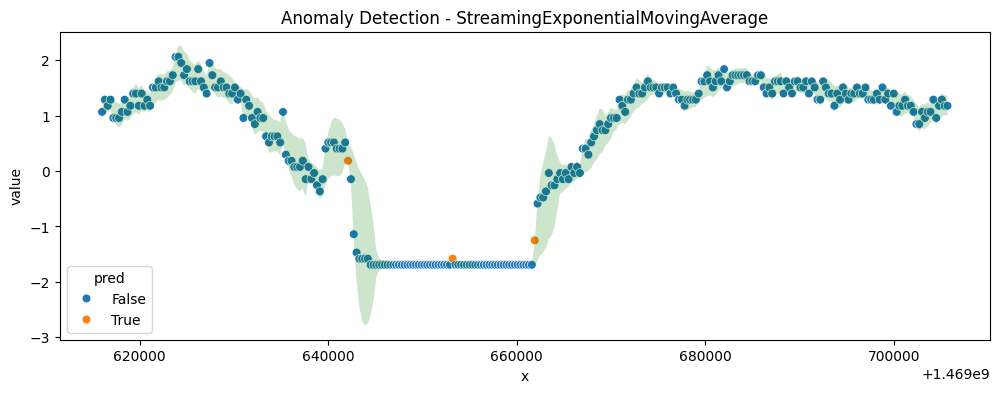

In [95]:
parameters = {'threshold': 1.5, 'alpha': 0.45}
plot_anomalies(df1_zoom, StreamingExponentialMovingAverage, parameters, dumping=True)

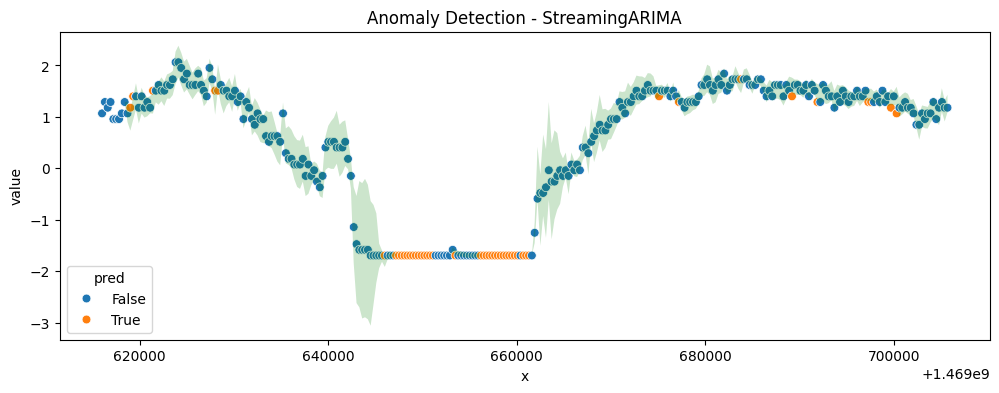

In [96]:
parameters = {'threshold': 1.5, 'order': (4, 1, 2)}
plot_anomalies(df1_zoom, StreamingARIMA, parameters, dumping=True)

(4) **Seasonal Moving Average** is a time-based algorithm that relies on previous days to make predictions. It did not fit for these two sample use cases because it is small amount of non-seasonal data.
(5) In summary, it is important to use the appropriate algorithm for the type of data being analyzed. In the case of non-seasonal data, algorithms such as the **Exponential Moving Average** or the **Holt-Winters** algorithm may be more suitable for anomaly detection. These algorithms are able to adapt to changes in the data and do not rely on seasonal patterns for their analysis. 